In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


## Looking at the HRF as a Gaussian process

The haemodynamic response function in BOLD fMRI is a impulse response to neural activity. Its characteristic shape can be described in a stylized manner as a difference of gamma functions, but in reality, not all HRFs adhere to that shape, and they vary significantly across the brain.

It thus becomes interesting to estimate the HRF. If event presentation times and measurement times can be placed on the same temporal grid (e.g. event presentation every 4 seconds, measurement every 2 seconds -> grid of 2 seconds), then one can attempt to estimate the HRF as a simple vector of entries covering a certain number of measurement points.

If the greatest common divisor of the event presentation and measurement grids is very small, then the HRF has to be oversampled strongly in order to accommodate both grids adequately. This necessitates more data and smoothness priors to be able to calculate a good estimate.

Taking one step further, one can assume the HRF to be an entirely continuous function, drawn from a distribution of functions. The usual choice of distribution on functions is the Gaussian Process distribution.

In [2]:
from nistats import hemodynamic_models

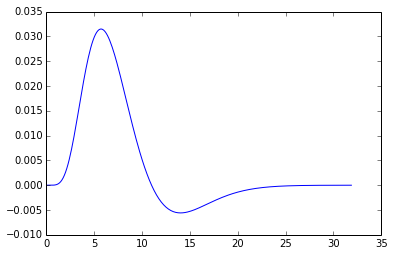

In [3]:
TR, oversampling, time_length = 2., 16., 32.
hrf = hemodynamic_models.glover_hrf(tr=TR, oversampling=oversampling)
plt.plot(np.arange(0., time_length, TR / oversampling), hrf)

## Estimating a Gaussian Process

The Gaussian process distribution is a distribution over functions such that when evaluated on a finite number of points, the covariance matrix of the function values is defined by a pairwise kernel function.

Differently put, a function $f:\mathbb{R}\rightarrow\mathbb{R}$ is a Gaussian process if for all $x\in\mathbb R$, $f(x)$ is a random variable and that for all $x_1, \dots, x_n\in\mathbb R$ the vector $(f(x_1), \dots, f(x_n))^T$ follows a Gaussian distribution with mean $(\mu(x_1), \dots, \mu(x_n))^T$ and covariance $K$ with $$K = \left(\begin{array}{cccc}k(x_1, x_1) & k(x_1, x_2) & \dots & k(x_1, x_n)\\\vdots & \ddots & {} & \vdots\\k(x_{n-1}, x_1) & {} & \ddots & {}\\k(x_n, x_1) & \dots & \dots & k(x_n, x_n)\end{array}\right),$$
where $k:\mathbb R^2\rightarrow\mathbb R$ is the covariance function or covariance kernel. It must be *positive definite*, which means that all covariance matrices it gives rise to must be positive semi-definite.

If this is the case, we can write
$$f\sim\mathcal{GP}(\mu, k)$$

So how does estimating one of these work? Well, measuring a Gaussian process, i.e. obtaining a function value, say in $x_1$, means that we know the value of the Gaussian random variable $f(x_1)$ to be e.g. $y_1$. Taking this information into account is thus equivalent to conditioning on $f(x_1) = y_1$. 

Now, a Gaussian distribution conditional to knowing some of its variable outcomes remains a Gaussian distribution, just with different parameters, and there is a closed form expression to obtain it.

Let $y\in\mathbb{R}^N\sim\mathcal N(\mu, \Sigma)$ and let the values of $y_0, \dots, y_{n-1}$ be known for $n < N$. Then what is the distribution of the remaining points? If we write $\Sigma^{11}$ to be the covariance matrix of $y^1 = (y_0, \dots, y_{n-1})$, $\Sigma^{22}$ to be the covariance matrix of $y^2 = (y_n, \dots, y_{N-1})$ and $\Sigma^{21}$ to be the cross-covariance between the two, then we can write
$$\Sigma = \left(\begin{array}{c|c}\Sigma^{11} & {\Sigma^{21}}^T\\\hline\Sigma^{21}&\Sigma^{22}\end{array}\right)$$
If we further let $\mu^1 = (\mu_0,\dots, \mu_{n-1})^T$ and $\mu^2 = (\mu_n,\dots,\mu_{N-1})^T$, then 
$$y_2\big|\{y_1 = a\}\sim \mathcal N(\bar\mu, \bar\Sigma)$$
with $$\bar \mu = \mu^2 - \Sigma^{21}{\Sigma^{11}}^{-1}(\mu^1 - a)$$ and 
$$\bar\Sigma = \Sigma^{22} - {\Sigma^{21}}^T{\Sigma^{11}}^{-1}\Sigma^{21}$$

This extends immediately to our Gaussian process setting, since all the points we will ever look at are going to be finite in number.

### A minimal GP estimation example
Let's take $f(x) = \sin(x)$

In [4]:
def f(x):
    return np.sin(x)

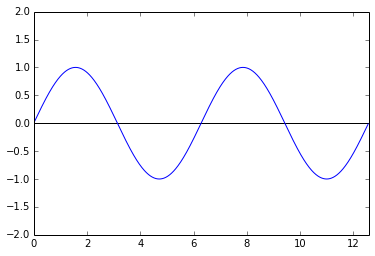

In [5]:
xs = np.arange(0, 4 * np.pi, 0.01)
ys = f(xs)

plt.plot(xs, ys)
plt.axis([0, 4 * np.pi, -2, 2])
plt.hlines([0], 0, 4 * np.pi)

Now lets measure this function in a finite number of random points

[0, 12.566370614359172, -2, 2]

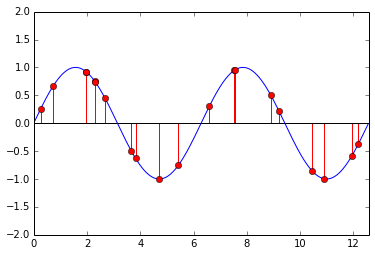

In [6]:
rng = np.random.RandomState(42)
xms = rng.uniform(0, 4 * np.pi, 20)
ms = f(xms)
plt.plot(xs, ys, 'b')
plt.plot(xms, ms, 'ro')
for xm, m in zip(xms, ms):
    plt.vlines([xm], 0, m, 'r')
plt.hlines([0], 0, 4 * np.pi)
plt.axis([0, 4 * np.pi, -2, 2])

For our Gaussian process distribution let's assume a zero mean $\mu = 0$ for simplicity. Let us further choose a covariance kernel that encodes smoothness, such as a simple Gaussian kernel with kernel width represented by a hyperparameter $\gamma$:
$$k_\gamma(x, y) = \exp\left(-\frac{1}{\gamma}\|y - x\|^2\right)$$

Let us define this kernel as a python function such that it can be evaluated on several points at once and plot the similarity matrices

In [7]:
def k(xs, ys, gamma=1.):
    xs, ys = map(np.atleast_1d, (xs, ys))
    diffs_squared = (xs.reshape(-1, 1) - ys.reshape(-1)) ** 2
    return np.exp(-diffs_squared / gamma)

(-0.5, 1256.5, 1256.5, -0.5)

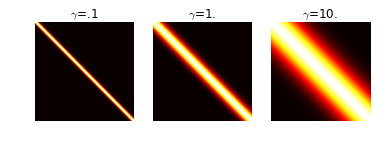

In [49]:
sim1 = k(xs, xs, gamma=.1)
sim2 = k(xs, xs, gamma=1.)
sim3 = k(xs, xs, gamma=10.)
plt.subplot(1, 3, 1)
plt.imshow(sim1)
plt.title('$\gamma$=.1')
plt.axis('off')
plt.hot()
plt.subplot(1, 3, 2)
plt.imshow(sim2)
plt.title('$\gamma$=1.')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sim3)
plt.title('$\gamma$=10.')
plt.axis('off')

In [55]:
print np.diag(sim1).sum()
print np.diag(sim2)
print np.diag(sim3)

1257.0
[ 1.  1.  1. ...,  1.  1.  1.]
[ 1.  1.  1. ...,  1.  1.  1.]


Let us apply the Gaussian conditioning as follows:
1. Let's take as $y_0, \dots, y_{n-1}$ the known function values, indicated by the red dots, ie the `ms` measured in `xms`.
2. Let's take as $y_n, \dots, y_N$ the function evaluated on an arbitrarily fine sampling grid, which we would like to plot the function with, e.g. the `xs`
3. We can then do a prediction using the mean of the conditional distribution
4. We have an estimate of the variance of the function measurements by looking at the diagonal of the conditional covariance matrix

In [9]:
gamma = 1.
n = len(xms)
all_xs = np.concatenate([xms, xs])
N = len(all_xs)
Sigma = k(all_xs, all_xs, gamma=gamma)
Sigma_11 = Sigma[:n, :n]
Sigma_22 = Sigma[n:, n:]
Sigma_21 = Sigma[n:, :n]
mu_bar = np.dot(Sigma_21, np.linalg.inv(Sigma_11)).dot(ms)
Sigma_bar = Sigma_22 - Sigma_21.dot(np.linalg.inv(Sigma_11)).dot(Sigma_21.T)

/home/aina/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


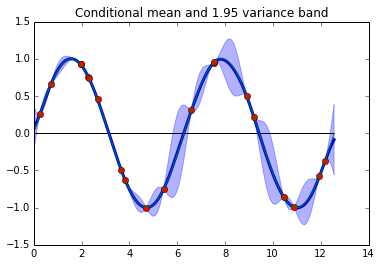

In [10]:
plt.plot(xs, mu_bar, 'b', lw=3)
plt.plot(xms, ms, 'ro')
plt.plot(xs, ys, 'g', lw=1)
plt.hlines([0], xs.min(), xs.max())
std = np.sqrt(np.diag(Sigma_bar))
plt.fill_between(xs, mu_bar + 1.95 * std, mu_bar - 1.95 * std, color=(0.,0., 1., .3))
plt.title('Conditional mean and 1.95 variance band')

That doesn't look too bad. As a matter of fact, the green line, representing the true function `f` isn't even visible because the conditional mean fits so well. This is a stroke of luck however, since by chance the width of the kernel corresponds somewhat to the with of variation of our sinusoid. We can observe a degradation if we vary `gamma`. In order to do this a little systematically, let's write the mean-variance predictor as a function and restrict ourselves to outputting only the diagonal of the conditional covariance

In [11]:
def mean_variance_predict(x_train, y_train, x_test, kernel):
    all_xs = np.concatenate([x_train.ravel(), x_test.ravel()])
    n = len(x_train.ravel())
    Sigma = kernel(all_xs, all_xs)
    Sigma_11 = Sigma[:n, :n]
    Sigma_22 = Sigma[n:, n:]
    Sigma_21 = Sigma[n:, :n]
    Sigma_11_inv = np.linalg.inv(Sigma_11)
    mu_bar = Sigma_21.dot(Sigma_11_inv.dot(y_train))
    var_bar = np.diag(Sigma_22) - np.einsum('ij, ji -> i', Sigma_21, np.dot(Sigma_11_inv, Sigma_21.T))
    return mu_bar, var_bar

/home/aina/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


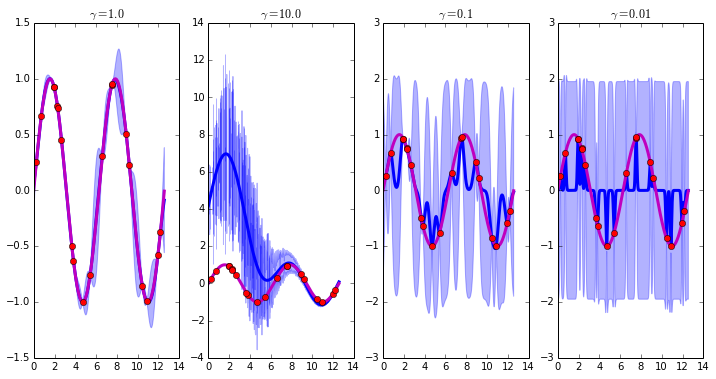

In [12]:
from functools import partial
gammas = [1., 10., .1, .01]
kernels = [partial(k, gamma=gamma) for gamma in gammas]
plt.figure(figsize=(12, 6))
for i, (kernel, gamma) in enumerate(zip(kernels, gammas)):
    mu_bar, var_bar = mean_variance_predict(xms, ms, xs, kernel)
    std = np.sqrt(var_bar)
    plt.subplot(1, len(gammas), i + 1)
    plt.plot(xs, mu_bar, 'b', lw=3)
    plt.plot(xs, ys, 'm', lw=3)
    plt.fill_between(xs, mu_bar + 1.95 * std, mu_bar - 1.95 * std, color=(0., 0., 1., .3))
    plt.plot(xms, ms, 'ro')
    plt.title('$\gamma={}$'.format(gamma))

As we can see for different kernel widths, the GP estimation can go quite horribly bad!

Note that for `gamma=10`, the problem becomes unstable and for `gamma << 1` the kernel width does not fit the smoothness 'style' of the function.

**Conclusion:** We must set `gamma` very wisely, either data-driven or with prior information.

**TO DO**:
- evaluate parameter selection via gradient descent like in sklearn Gaussian Process module, in case you have the gradient of the kernel in the hyperparameter, which is of course the case for the Gaussian kernel.
- another option would be grid search

### A minimal GP example with noise

Now let's take into account a very important component neglected until now: Noise!

Let $\varepsilon(x)\sim\mathcal N(0, \sigma)$ and let's assume it's i.i.d. white noise. This means that 
$$\textrm{cov}(\varepsilon(x_1), \varepsilon(x_2)) = \delta(x_1 - x_2)$$

Let us further assume that the noise is statistically independent from our signal GP
$$\varepsilon(x_1)\bot f(x_2)\quad\forall x_1,x_2,$$
whether $x_1=x_2$ or not.

#### Noisy data model
From now on, we will factor in noise, so our measurement model becomes
$$y(x) = f(x) + \varepsilon(x),$$
where $f\sim\mathcal{GP}(\mu, k)$ and $\forall x, \varepsilon(x)\sim\mathcal N(0,\sigma)$.

For a finite number of measurement points $x_0, \dots, x_{n-1}$, let us evaluate the covariance matrix of the $y_i = y(x_i)$:

$$\textrm{cov}(y_i, y_j) = \textrm{cov}(f(x_i) + \varepsilon(x_i), f(x_j) + \varepsilon(x_j)) =\\= \textrm{cov}(f(x_i), f(x_j)) + \textrm{cov}(f(x_i), \varepsilon(x_j)) + \textrm{cov}(\varepsilon(x_i), f(x_j)) + \textrm{cov}(\varepsilon(x_i), \varepsilon(x_j))=\\=\textrm{cov}(f(x_i), f(x_j)) + \textrm{cov}(\varepsilon(x_i), \varepsilon(x_j))=\\=k(x_i, x_j) + \sigma^2\delta(x_i - x_j)$$

If we set the kernel matrix $K^1\in\mathbb{R}^{n\times n}$ to be $K_{ij} = k(x_i, x_j)$, then our covariance matrix $\Sigma^1_{ij} = \textrm{cov}(y_i, y_j)$ reads
$$\Sigma^1 = K^1 + \sigma^2\textrm{Id},$$

which is very much akin to the regularized Gram matrix of Ridge regression. We conclude that iid Gaussian noise leads to a ridge regression type penalization of the covariance.

Generalizing from noisy measurements in a finite number of points to other measurement points works in exactly the same way as before.

We add the new points and calculate the full covariance matrix, which we then condition against the known (now noisy) measurements. Since we are interested in obtaining measurement distributions in the new coordinates and not noisy measurement distributions, we do not add the noise covariance of the new points, so we set
$$\Sigma = \left(\begin{array}{c|c}K^{1} +\sigma^2\textrm{Id} & {\Sigma^{21}}^T\\\hline\Sigma^{21}&\Sigma^{22}\end{array}\right),$$
and condition $\mathcal N(0, \Sigma)\big | \{y(x_0) = v_0, \dots, y(x_{n-1}) = v_{n-1}\}$, to obtain $y^2 = (y(x_n), \dots, y(x_{N-1}))\sim\mathcal N(\bar\mu, \bar\Sigma)$
with $$\bar \mu = \mu^2 - \Sigma^{21}(K^1 + \sigma^2\textrm{Id})^{-1}(\mu^1 - a)$$ and 
$$\bar\Sigma = \Sigma^{22} - {\Sigma^{21}}^T(K^1 + \sigma^2\textrm{Id})^{-1}\Sigma^{21}$$

#### A simple example of noisy GP estimation

So let's take a look at this for our simple sinusoid function. We add three error levels and estimate accordingly.

In [13]:
sigmas = [.1, 1., 10.]
noises = [rng.randn(len(ms)) * sigma for sigma in sigmas]

noisy_measurements = [ms + noise for noise in noises]

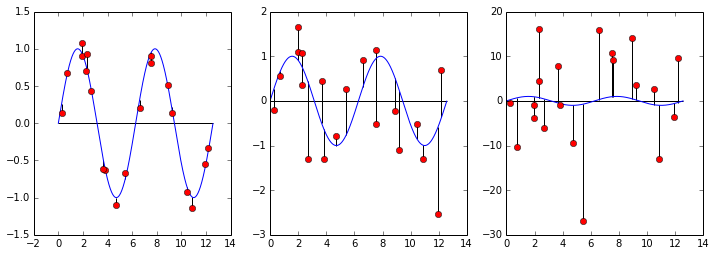

In [14]:
plt.figure(figsize=(12, 4))
for i, nm in enumerate(noisy_measurements):
    plt.subplot(1, len(sigmas), i + 1)
    plt.plot(xs, ys)
    plt.plot(xms, nm, 'ro')
    for xx, yy in zip(xms, nm):
        plt.vlines([xx], f(xx), yy)
    plt.hlines([0], 0, 4 * np.pi)

Let's update our estimation/prediction function to be able to incorporate the regularization term:

In [15]:
def mean_variance_predict(x_train, y_train, x_test, kernel, sigma_squared=None):
    all_xs = np.concatenate([x_train.ravel(), x_test.ravel()])
    n = len(x_train.ravel())
    Sigma = kernel(all_xs, all_xs)
    Sigma_11 = Sigma[:n, :n]
    Sigma_22 = Sigma[n:, n:]
    Sigma_21 = Sigma[n:, :n]
    if sigma_squared is not None:
        Sigma_11 = Sigma_11 + sigma_squared * np.eye(n)
    Sigma_11_inv = np.linalg.inv(Sigma_11)
    mu_bar = Sigma_21.dot(Sigma_11_inv.dot(y_train))
    var_bar = np.diag(Sigma_22) - np.einsum('ij, ji -> i', Sigma_21, np.dot(Sigma_11_inv, Sigma_21.T))
    return mu_bar, var_bar

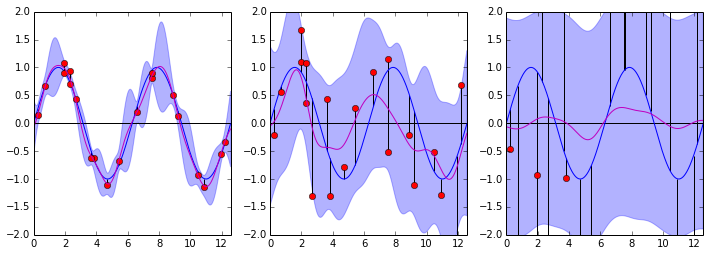

In [16]:
plt.figure(figsize=(12, 4))
for i, (sigma, nm) in enumerate(zip(sigmas, noisy_measurements)):
    plt.subplot(1, len(sigmas), i + 1)
    plt.plot(xs, ys)
    plt.plot(xms, nm, 'ro')
    for xx, yy in zip(xms, nm):
        plt.vlines([xx], f(xx), yy)
    plt.hlines([0], 0, 4 * np.pi)
    
    mu_bar, var_bar = mean_variance_predict(xms, nm, xs, partial(k, gamma=1,), sigma ** 2)
    plt.plot(xs, mu_bar, 'm')
    plt.fill_between(xs,
                     mu_bar - 1.96 * np.sqrt(var_bar),
                     mu_bar + 1.96 * np.sqrt(var_bar), color=(0, 0, 1, .3))
    plt.axis([0, 4 * np.pi, -2, 2])

Contrary to above, these plots are all on the same scale. We observe that the true solution at least always lies within the variance band around the estimated solution, but that noise obviously degrades the estimate. In these extremely noisy cases, we would need many more data points for the estimation.

We can try this now:

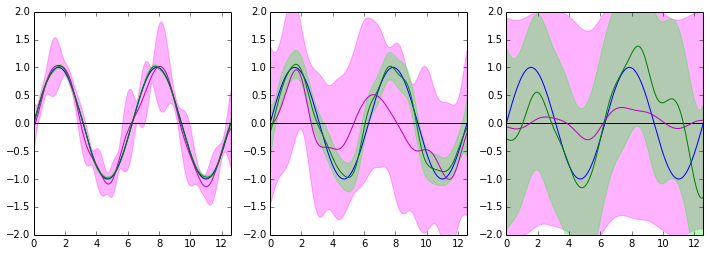

In [17]:
many = 1000
xms_many = np.concatenate([xms, rng.uniform(0, 4 * np.pi, many - len(xms))])
ms_many = f(xms_many)
noises_many = [np.concatenate([noise, rng.randn(many - len(xms)) * sigma])
               for (noise, sigma) in zip(noises, sigmas)]
nms_many = [ms_many + noise for noise in noises_many]

plt.figure(figsize=(12, 4))
for i, (sigma, nm, nm_many) in enumerate(zip(sigmas, noisy_measurements, nms_many)):
    plt.subplot(1, len(sigmas), i + 1)
    plt.plot(xs, ys)
    plt.hlines([0], 0, 4 * np.pi)
    
    mu_bar, var_bar = mean_variance_predict(xms, nm, xs, partial(k, gamma=1,), sigma ** 2)
    plt.plot(xs, mu_bar, 'm')
    plt.fill_between(xs,
                     mu_bar - 1.96 * np.sqrt(var_bar),
                     mu_bar + 1.96 * np.sqrt(var_bar), color=(1, 0, 1, .3))
    mu_bar_many, var_bar_many = mean_variance_predict(xms_many, nm_many, xs, partial(k, gamma=1,), sigma ** 2)
    plt.plot(xs, mu_bar_many, 'g')
    plt.fill_between(xs,
                     mu_bar_many - 1.96 * np.sqrt(var_bar_many),
                     mu_bar_many + 1.96 * np.sqrt(var_bar_many), color=(0, 1, 0, .3))
    
    plt.axis([0, 4 * np.pi, -2, 2])

So here the magenta line and band was estimated with our original 20 points, and the green one with 1000 points (including the original 20 as first ones). We observe that for the small noise case the variance band is pretty much nonexistent, for the medium noise case it is very tight around the function and in the high noise case the band is slightly better than before, but the estimate is still shitty.

**Important** We need to make sure to sample enough points to deal with the given noise level. This will also be influenced by our choice of kernel. This simple smoothness kernel seems to need a lot of samples.

**TO DO** find out which guarantees could hold for us here.

But note that this isn't everything: How did we know which regularization to put? Well, we chose it through the noise level, which we knew. But we won't know it in real life. So let's check what happens if we put different noise levels from the true one:

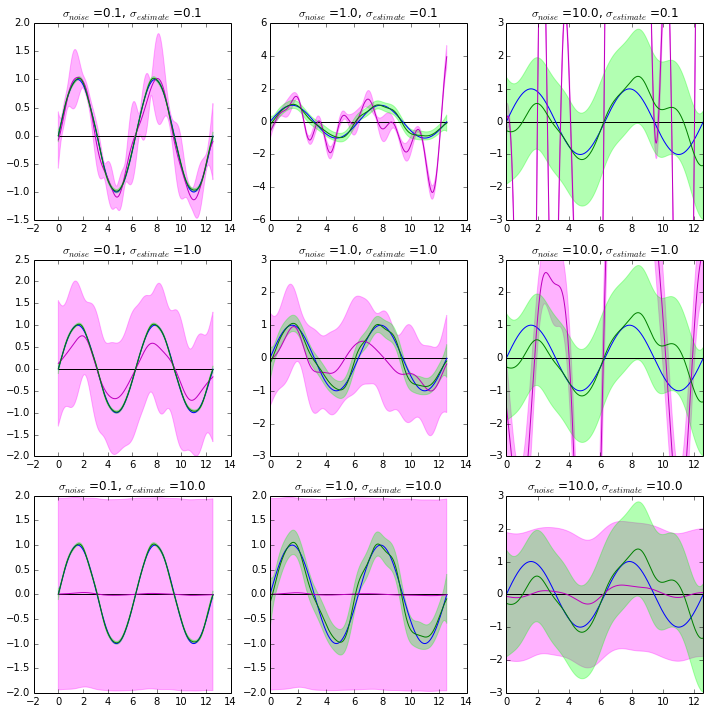

In [18]:
plt.figure(figsize=(12, 12))
i = 0
for sigma_estimate in sigmas:
    for sigma, nm, nm_many in zip(sigmas, noisy_measurements, nms_many):
        i += 1
        plt.subplot(len(sigmas), len(sigmas), i)
        plt.plot(xs, ys)
        plt.hlines([0], 0, 4 * np.pi)
    
        mu_bar, var_bar = mean_variance_predict(xms, nm, xs,
                                                    partial(k, gamma=1,), sigma_estimate ** 2)
        plt.plot(xs, mu_bar, 'm')
        plt.fill_between(xs,
                     mu_bar - 1.96 * np.sqrt(var_bar),
                     mu_bar + 1.96 * np.sqrt(var_bar), color=(1, 0, 1, .3))
        mu_bar_many, var_bar_many = mean_variance_predict(xms_many, nm_many, xs,
                                                          partial(k, gamma=1,), sigma ** 2)
        plt.plot(xs, mu_bar_many, 'g')
        plt.fill_between(xs,
                     mu_bar_many - 1.96 * np.sqrt(var_bar_many),
                     mu_bar_many + 1.96 * np.sqrt(var_bar_many), color=(0, 1, 0, .3))
        plt.title('$\sigma_{{noise}}$ ={}, $\sigma_{{estimate}}$ ={}'.format(sigma, sigma_estimate))
 
    plt.axis([0, 4 * np.pi, -3, 3])

Now let's take a look at the columns. That means for one data noise level, we look at different GP estimations using different regularizations, thus different suppositions of noise variance.

Three observations have to be made:
1. With increasing penalty, the variance band around the estimates increases. Why? Well, because the variance band directly reflects the assumed noise level. If we assume it wrong, then this will translate directly into the estimate of the variance band!
2. The solutions shrink towards zero with increasing penalty. Why is this? Well, it is a fundamental property of Ridge-type estimations (L2-penalty corresponds to adding identity to diagonal) that it shrinks the coefficients towards zero. Each Ridge penalty can be mapped exactly to a euclidean norm radius within which the estimates will land. In the case of Gaussian Processes, this shrinkage will be towards the mean function. If the mean function is 0, as it is here for simplification, then we shrink towards that.
3. The $1.96\sigma$ variance band never exceeds $1.96$. This is because the kernel matrix variance estimate will always lie between 0 and 1. This can be remedied by adding a hyperparameter factor scaling the kernel matrix entries. It will have to be fit though.

**TO DO** : Figure out if by gradient descent or some other estimation we can estimate the noise parameter sigma correctly.

**Important** : The shrinkage can be an advantage or a disadvantage. If we use a zero-mean GP to estimate the HRF, then stronger penalization will cause a shrinkage towards zero, which constitutes a bias and will alter all our estimates. However, we can also use a more appropriate mean function. If we do this, then in the very noisy (strongly penalized) case, we will just shrink towards the mean template given to us. This can become a dynamic way of having more or less flexibility in the estimate.

**TO DO** : Assess possibilities for the mean function: zero, canonical HRF, linear combination of low-frequency Fourier components as standard over brain, use a GP to estimate the mean function (hierarchical GP, see Emily Fox's work)

## Writing a GLM with a GP HRF

Let $h\sim\mathcal{GP}(\mu, K)$ be an HRF, where $\mu:[0, T]\rightarrow\mathbb{R}$ and $K:[0, T]^2\rightarrow\mathbb{R}$ and $T > 0$ is the duration of the HRF. Let $X_h\in\mathbb{R}^{N\times P}$ be the design matrix using the HRF. Let $V$ explicitly contain nuissance regressors so that $X^h$ can be concerned with only the signal. Then for a given voxel $v$, its activity can be modeled as
$$y_v = X^h\beta^v + V\delta^v + \varepsilon_v,$$
where $\varepsilon_v\sim\mathcal N(0,\sigma_v)$ (or AR$(1, \sigma_v, \rho_v)$).

Let $e_p$ be an event train for the condition $p\in\{1, \dots, P\}.$ This can be boxcar type activations or singular spike-like events. Let us focus on the latter for the moment. Let us assume that event train $e_p$ has $M_p$ spike type events of intensity $\alpha_m^p$. Then we could write each event train as

$$e_p(t) = \sum_{m=1}^{M_p}\alpha_m^p\delta(t - \tau_m^p)$$

We can then write our continuous regressors as the convolution with the HRF. (It is quite clear that the convolution is defined to go over the support of the HRF, which is of length $T$. We could make it clear by embedding it in $\mathbb R$ by the slight abuse of notation $h\mathbb 1_{[0, T]}$, but let's not make notation heavy). Our regressors then are simply

$$x_p^h = h\ast e_p$$

If we write scanner measurement times as $t_n = nTR$ with $n=0,\dots, N-1$, then we can evaluate our regressors in these points to get the scanner measurement. This yields

$$X^h_{n, p} = x_p^h(t_n)$$

This defines all the entries of our design matrix. Let's draw some of this.

In [19]:
n_events = 20
event_distances = rng.uniform(2, 6, n_events)
event_times = np.cumsum(event_distances)
event_intensities = rng.uniform(1, 2, n_events)

n_event_types = 4
event_types = rng.permutation(n_events) % n_event_types
max_time = np.floor(event_times[-1] + 4)


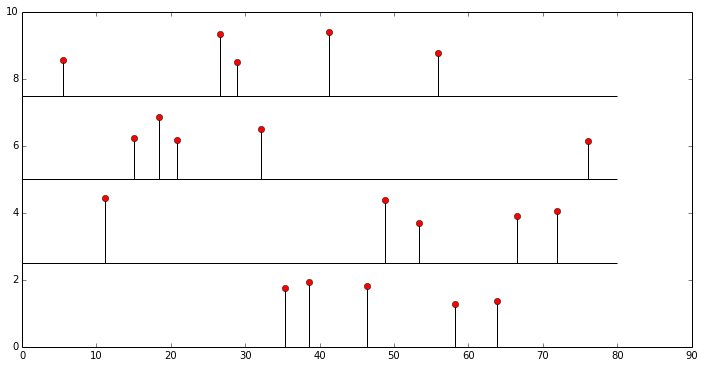

In [20]:
plt.figure(figsize=(12, 6))
plt.hlines(np.arange(n_event_types) * 2.5, 0, max_time)
for etype, etime, eintensity in zip(event_types, event_times, event_intensities):
    plt.vlines([etime], etype * 2.5, etype * 2.5 + eintensity)
plt.plot(event_times, event_types * 2.5 + event_intensities, 'ro')

These are the event regressors $e_p(t)$. We now convolve them with an HRF

In [21]:
grid_step = 0.01  # here we are actually making an oversampled grid to be able to display stuf
time_grid = np.mgrid[0:max_time:grid_step]

event_time_indices = (event_times // grid_step).astype(int)
event_indicators = np.zeros((len(time_grid), n_event_types))
event_indicators[event_time_indices, event_types] = event_intensities

In [22]:
#plt.figure(figsize=(12, 4))
#plt.plot(time_grid,event_indicators + np.arange(4) * 2.5)
#plt.yticks([])

In [25]:
from scipy.signal import convolve

TR, oversampling, time_length = 1., 1. / grid_step, 32.
hrf = hemodynamic_models.glover_hrf(tr=TR, oversampling=oversampling, time_length=time_length)

hrf /= hrf.max()
continuous_regressors = convolve(event_indicators, hrf[:, np.newaxis], mode='full')
continuous_regressors = continuous_regressors[:len(event_indicators)]

([<matplotlib.axis.YTick at 0x7f2a125a65d0>,
 <a list of 4 Text yticklabel objects>)

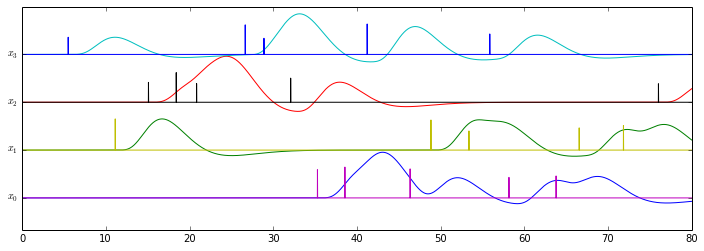

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(time_grid, continuous_regressors + np.arange(4) * 3)
plt.plot(time_grid, event_indicators + np.arange(4) * 3)
plt.yticks(np.arange(4) * 3, ['$x_{p}$'.format(p=p) for p in range(4)])

So with a fixed HRF $h$, we would like to model all the signal measurements using these regressors by forming linear combinations. Obtaining the design matrix equates to measuring on a regular temporal grid, which we indicate next using vertical lines.

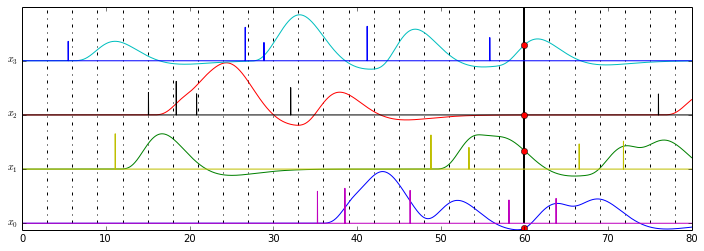

In [27]:
TR=3

plt.figure(figsize=(12, 4))
plt.plot(time_grid, continuous_regressors + np.arange(4) * 3)
plt.plot(time_grid, event_indicators + np.arange(4) * 3)
plt.yticks(np.arange(4) * 3, ['$x_{p}$'.format(p=p) for p in range(4)])
plt.vlines(np.arange(0, time_grid.max(), TR), 0, 12, linestyle='-.')
plt.vlines([60], 0, 12, lw=2)
plt.plot([60] * 4, np.arange(4) * 3 + continuous_regressors[60 / grid_step],'ro')

The dash-dotted lines represent measurements.

Observe that at every measurement we will be confronted with a linear combination of the HRF evaluated in different points (see detail at second 60).

**Important** : We must be able to deal with linear combinations of measurements of a Gaussian Process - not only simple measurements. This will need a little extra reflection. Once it is clear how to estimate the Gaussian Process from linear combinations of measurements plus noise, we should be able to work with it.

Thus let us next figure out how to estimate a Gaussian process from finite linear noisy measurements before doing the same for the GLM

### Estimating a Gaussian Process from linear combinations of measurements

Consider a Gaussian Process $f\sim\mathcal N(\mu, K)$.

We will call a measurement $\varphi_n$ the following thing: There is a finite number of points $x_{i}$ for $i\in I_n$ where $I_n$ is a finite index set, and we can write the noisy measurement as

$$\varphi_n = \sum_{i\in I_n}\eta_i f(x_i) + \varepsilon_n$$

How do we estimate the parameters of the GP to predict now values? Exactly the same way as before: The $\varphi_n$ are linear combinations of Gaussians, hence Gaussians themselves. We can condition on these measurement values just like before. For this we first establish the covariance matrix

$$\Sigma_{nm} = \textrm{cov}(\varphi_n, \varphi_m)$$

By expanding the sums we obtain
$$\Sigma_{nm} = \sum_{i\in I_n, j\in I_m}\eta_i\eta_j k(x_i, x_j) + \sigma^2\delta_{nm}.$$
This means that the $\Sigma_{nm}$ are linear combinations of the kernel matrix evaluated in all points $k(x_i, x_j)$. The weights have a rank-1-structure, since they are the outer product of the $\eta$ vectors of each measurement.

To obtain the conditional mean and covariance for any new points, we need to add these points to the covariance and compute their covariances and cross-covariances. Their covariances, between e.g. $x_k$ and $x_l$, are simply $k(x_k, x_l)$. The cross-covariances between $x_k$ and $\varphi_n$ read

$$\textrm{cov}(f(x_k), \varphi_n) = \sum_{i\in I_n}\eta_i k(x_k, x_i)$$

Let's create some data to do this.

In [28]:
N = 15
num_points_to_measure = rng.randint(1, 5, N)  # each measure may see a different number of points
all_measurement_points = [rng.uniform(0, 4 * np.pi, num) for num in num_points_to_measure]
all_etas = [rng.randn(num) for num in num_points_to_measure]


This already specifies where we measure and with what weight. But it may be (not sure myself) nice to order these measurement points into one big array and work with indices into this array:

In [29]:
point_list = np.unique(np.concatenate(all_measurement_points))
point_indices = [np.where(mps[:, np.newaxis] == point_list)[1] for mps in all_measurement_points]

This way of writing gives us the possibility to create one common kernel matrix between all the positions and then index into it to calculate the linear combinations

In [30]:
def get_Sigma_phi(point_list, point_indices, etas, kernel):
    K = kernel(point_list, point_list)
    Sigma_phi = np.zeros((len(point_indices), len(point_indices)))
    for row, pi1, eta1 in zip(Sigma_phi, point_indices, etas):
        submatrix = K[pi1] * eta1[:, np.newaxis]
        for i, (pi2, eta2) in enumerate(zip(point_indices, etas)):
            row[i] = (submatrix[:, pi2] * eta2).sum()
    return Sigma_phi

**TO DO** This should be better evaluated using a sparse matrix indicating the measurements

Next lets get the cross-covariances between the $\varphi_n$ and new measurement points:

In [31]:
def get_Sigma_phi_cross(new_points, point_list, point_indices, etas, kernel):
    Kcross = kernel(new_points, point_list)
    Sigma_phi_cross = np.zeros((len(new_points), len(point_indices)))
    for column, pi, eta in zip(Sigma_phi_cross.T, point_indices, etas):
        column[:] = Kcross[:, pi].dot(eta)
    return Sigma_phi_cross

In [32]:
def mean_var_predict_lincomb(new_points, measurements, point_list, point_indices,
                                etas, sigma_noise, kernel):
    Sigma_phi = get_Sigma_phi(point_list, point_indices, etas, kernel)
    Sigma_phi_cross = get_Sigma_phi_cross(new_points, point_list, point_indices, etas, kernel)
    Sigma_new_points = kernel(new_points, new_points)
    
    Sigma_phi_reg_inv = np.linalg.inv(Sigma_phi +
                                          np.eye(Sigma_phi.shape[0]) * sigma_noise ** 2)
    mu_bar = Sigma_phi_cross.dot(Sigma_phi_reg_inv.dot(measurements))
    var_bar = np.diag(Sigma_new_points) - np.einsum('ij, ji -> i', 
                                                    Sigma_phi_cross,
                                                    np.dot(Sigma_phi_reg_inv,
                                                            Sigma_phi_cross.T))
    return mu_bar, var_bar

Let's try this out on our sinusoid with the points given. Let's make a helper function for the measurements before that.

In [33]:
def get_measurements(function, point_list, point_indices, etas):
    function_values = function(point_list)
    measurements = np.zeros(len(point_indices))
    for i, (pi, eta) in enumerate(zip(point_indices, etas)):
        measurements[i] = np.dot(function_values[pi], eta)
    return measurements

In [34]:
noise_level = .1
measurements = get_measurements(f, point_list, point_indices, all_etas) + noise_level * rng.rand(len(point_indices))

In [35]:
kernel = partial(k, gamma=1.)

In [36]:
mu_bar, var_bar = mean_var_predict_lincomb(xs, measurements, point_list,
                                           point_indices, all_etas, sigma_noise=noise_level,
                                          kernel=kernel)

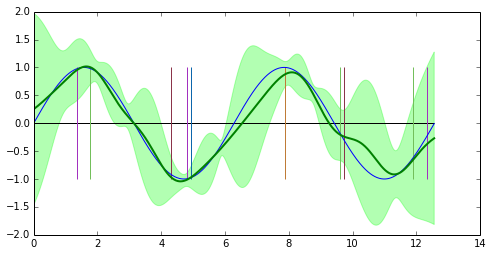

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(xs, ys)
plt.plot(xs, mu_bar, 'g', lw=2)
plt.fill_between(xs, mu_bar - 1.96 * np.sqrt(var_bar), mu_bar + 1.96 * np.sqrt(var_bar), color=(0, 1, 0, .3))
plt.hlines([0], 0, 4 * np.pi)

# show measurements 0-5
for i in range(5):
    plt.vlines(point_list[point_indices[i]], -1, 1, color=rng.uniform(0, 1, 3))

The measurements we made were on groups of random uniformly distributed points. Let's check what happens to the variance band if we select the points on a regular grid:

In [38]:
point_list_int = rng.randint(0, 12, len(point_list))

In [39]:
regular_measurements = get_measurements(f, point_list_int, point_indices, all_etas) + noise_level * rng.rand(len(point_indices))

In [40]:
mu_bar_reg, var_bar_reg = mean_var_predict_lincomb(xs, regular_measurements, point_list_int,
                                           point_indices, all_etas, sigma_noise=noise_level,
                                          kernel=kernel)

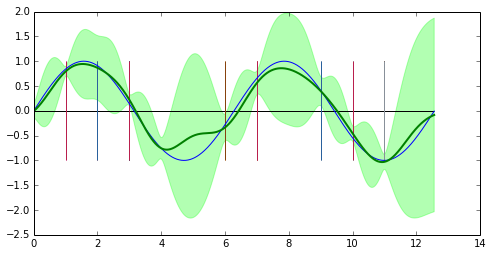

In [41]:
plt.figure(figsize=(8, 4))
plt.plot(xs, ys)
plt.plot(xs, mu_bar_reg, 'g', lw=2)
plt.fill_between(xs, mu_bar_reg - 1.96 * np.sqrt(var_bar_reg),
                 mu_bar_reg + 1.96 * np.sqrt(var_bar_reg), color=(0, 1, 0, .3))
plt.hlines([0], 0, 4 * np.pi)

# show measurements 0-10
for i in range(10):
    plt.vlines(point_list_int[point_indices[i]], -1, 1, color=rng.uniform(0, 1, 3))

It can be seen that a regular sampling grid causes high variance of the HRF estimate anywhere outside the grid points, whereas the uniform sampling creates a more uniform band.




**TO DO** All this has to be done for non-zero means when we move on to HRF estimation

## Estimating the HRF in a GLM

We would like to apply what we know to estimating HRF and activations. For this we need to figure our which measurements "see" which parts of the HRf in order to be able to write our GP estimation procedure accordingly.

Let us assume that for a voxel $v$ we know the activation values $\beta^v$ and that the temporal maximum length of the HRF is $L$. Then at a given measurement time $t_n = nTR$, the measurement value $y^v_n$ comes from
$$\sum_{p=1}^P\sum_{m=1}^{M_p}\alpha_m^p\beta^v_p\mathbb 1_{[0, L]}(t_n - \tau_m^p)h(t_n - \tau_m^p),$$
which basically just encodes all the events that are within one HRF length in the past, weighted by $\beta^v_p$ ($\alpha_m^p$ is the fixed intensity of the event itself).

In order to have a good interface, we will define the paradigm using standard convention `onset, duration, name, modulation` as columns of a pandas dataframe/csv file. We create two datasets like that, one with events placed on a grid commensurate with the measurements and one with jittered events. We use `nistats`' `check_paradigm` function to obtain the values from the dataframe.

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas

from nistats.experimental_paradigm import check_paradigm

In [43]:
rng = np.random.RandomState(42)
n_events = 200
n_blank_events = 50
event_spacing = 6

event_types = np.array(['evt_1', 'evt_2', 'evt_3', 'evt_4', 'evt_5', 'evt_6'])

all_times = (1. + np.arange(n_events + n_blank_events)) * event_spacing
non_blank_events = rng.permutation(len(all_times))[:n_events]
event_times = np.sort(all_times[non_blank_events])

names = event_types[rng.permutation(n_events) % len(event_types)]
regular_paradigm = pandas.DataFrame.from_dict(dict(onset=event_times, name=names))

jitter_min, jitter_max = -1, 1
jittered_event_times = event_times + rng.uniform(jitter_min, jitter_max, len(event_times))
jittered_paradigm = pandas.DataFrame.from_dict(dict(onset=jittered_event_times, name=names))

OK, now that both experimental paradigms are created, we can use nistats to create classical GLM design matrices with canonical HRF for them.

In [44]:
from nistats.design_matrix import make_design_matrix

TR = 2
measurement_times = np.arange(0., event_times.max() + 10, TR)
design_regular = make_design_matrix(measurement_times, paradigm=regular_paradigm, period_cut=64)
design_jittered = make_design_matrix(measurement_times, paradigm=jittered_paradigm, period_cut=64)

(-0.5, 751.5, 5.5, -0.5)

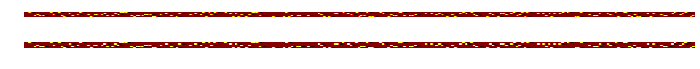

In [45]:
plt.figure(figsize=(12, 1))
plt.subplot(2, 1, 1)
plt.imshow(design_jittered[event_types].values.T, interpolation='nearest')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(design_regular[event_types].values.T, interpolation='nearest')
plt.axis('off')

Now, the $\eta_i$ of our linear combinations of measurements here become some $\alpha\beta$ value, where $\alpha$ is the fixed intensity of the event ("modulation") and $\beta$ is the current estimated activity value. We thus have to update our $\varphi$-kernel-matrix at every estimate and should write functions accommodating for this.

The first function we need is one that figures out, given event times, types and intensities, as well as measurement times and maximum length of the HRF, which parts of the HRF are "seen" by each measurement and with what alpha values (known) they are weighted and what with what beta values (unknown, so just indices saying which one) they are weighted.

In [46]:
def get_hrf_measurements(frame_times, onsets, names, hrf_length=32., modulation=None):
    
    if modulation is None:
        modulation = np.ones_like(onsets)
    
    time_differences = frame_times[:, np.newaxis] - onsets
    scope_masks = (time_differences > 0) & (time_differences < hrf_length)
    belong_to_measurement, which_event = np.where(scope_masks)
    
    unique_events, event_type_indices = np.unique(names, return_inverse=True)

    hrf_measurement_points = [list() for _ in range(len(frame_times))]
    alphas = [list() for _ in range(len(frame_times))]
    beta_indices = [list() for _ in range(len(frame_times))]
    visible_events = [list() for _ in range(len(frame_times))]
    
    for frame_id, event_id in zip(belong_to_measurement, which_event):
        hrf_measurement_points[frame_id].append(time_differences[frame_id, event_id])
        alphas[frame_id].append(modulation[event_id])
        beta_indices[frame_id].append(event_type_indices[event_id])
        visible_events[frame_id].append(event_id)
    
    return hrf_measurement_points, visible_events, alphas, beta_indices, unique_events
    

What we want to do here is the following

1. Given activation values $\beta_p$, estimate the HRF
2. Given the HRF, estimate the activation values.

But what does that really actually mean? Let's reformulate, because it seems interesting

- Given measurements of linear superpositions of HRF evaluations in different points, estimate what the *actual* value of the HRF was in those points in order to build a design matrix

So basically what we are doing is undoing these linear combinations to be able to get the actual values of the HRF at all these measurement points. Then we sum them back up again according to event type and what each measurement saw. So it is basically estimating one set of linear combinations of HRF measurements from another. While we should first do the full thing, i.e. estimate HRF points and recombine after, it can maybe be interesting to just do the combined evaluation from the beginning (which in a later step may give easier access to covariance predictions as well)

In [47]:
def get_alpha_weighted_kernel_matrix(hrf_measurement_points, alphas, kernel,
                                    evaluation_points=None, return_eval_cov=False):
    """This function computes the kernel matrix of all measurement points,
    potentially redundantly per measurement points, just to be sure we identify
    things correctly afterwards.
    
    If evaluation_points is set to None, then the original hrf_measurement_points will be used
    """
    hrf_measurement_points = np.concatenate(hrf_measurement_points)
    if evaluation_points is None:
        evaluation_points = hrf_measurement_points
    alphas = np.concatenate(alphas)
    kernel_matrix = kernel(hrf_measurement_points, hrf_measurement_points)
    cross_kernel_matrix = kernel(evaluation_points, hrf_measurement_points)
    alpha_weight = alphas[:, np.newaxis] * alphas
    pre_cov_matrix = kernel_matrix * alpha_weight
    pre_cross_cov_matrix = cross_kernel_matrix * alphas
    if return_eval_cov:
        return pre_cov_matrix, pre_cross_cov_matrix, kernel(evaluation_points, evaluation_points)
    
    return pre_cov_matrix, pre_cross_cov_matrix

In [48]:
from scipy.sparse import coo_matrix
def get_hrf_values_from_betas(y_values, beta_values, alpha_weighted_kernel_cov_matrix, 
                              alpha_weighted_kernel_cross_cov_matrix, beta_indices,
                              sigma_noise, Sigma22=None):
    # we first create the kernel matrix, by appropriately collapsing the precalculated kernel
    # matrix using the beta-values and the structure of the measurements

    # Let's try to do this "elegantly" using a sparse matrix (although the data structure is
    # already so awful that I don't know if this is elegance or useless complication ... ;) )
    
    # If Sigma22 is specified, also output the variances
    col_coordinates = np.concatenate([i * np.ones(len(beta_ind))
                                      for i, beta_ind in enumerate(beta_indices)])
    
    all_betas = beta_values[np.concatenate(beta_indices).astype(int)]
    row_coordinates = np.arange(len(all_betas))
    collapser = coo_matrix((all_betas, (row_coordinates, col_coordinates)),
                           shape=(len(all_betas), len(beta_indices))).tocsc()
    cov_matrix = collapser.T.dot(collapser.T.dot(
            alpha_weighted_kernel_cov_matrix).T).T   # awful, I know. sparse matrix problem
    cross_cov_matrix = collapser.T.dot(alpha_weighted_kernel_cross_cov_matrix.T).T  # again
    inv_reg_cov_matrix = np.linalg.inv(cov_matrix +
                                           np.eye(cov_matrix.shape[0]) * sigma_noise ** 2)
    mu_bar = cross_cov_matrix.dot(inv_reg_cov_matrix.dot(y_values))
    if Sigma22 is not None:
        var_bar = np.diag(Sigma22) - np.einsum('ij, ji -> i', 
                                                    cross_cov_matrix,
                                                    np.dot(inv_reg_cov_matrix,
                                                            cross_cov_matrix.T))
        return mu_bar, var_bar
    return mu_bar


So let's try this out! Let's give ourselves some realistic beta values by generating a y-vector with randomly chosen beta-values and then estimating them back using least squares.

The HRF estimation should give us the canonical HRF if the measurements weren't too noisy. Ideally the degradation should also happen gracefully.

In [552]:
paradigm = jittered_paradigm
full_design = design_jittered

In [553]:
kernel = partial(k, gamma=10.)

names, onsets, durations, modulation = check_paradigm(paradigm)
frame_times = np.arange(0, onsets.max() + 10, 2)
hrf_measurement_points, visible_events, alphas, beta_indices, unique_events = \
    get_hrf_measurements(frame_times, onsets, names, modulation=modulation, hrf_length=32)

xs = np.arange(0, 32., .2)

In [554]:
design = full_design[event_types].values  # forget about drifts for the moment
beta = rng.randn(len(event_types))
noise_level = .01
ys = design.dot(beta) + rng.randn(design.shape[0]) * noise_level
beta_estimated = np.linalg.pinv(design).dot(ys)

In [555]:
#evaluation_points = xs
#evaluation_points = np.concatenate(hrf_measurement_points)
evaluation_points = None

pre_cov_matrix, pre_cross_cov_matrix, Sigma22 = get_alpha_weighted_kernel_matrix(
    hrf_measurement_points, alphas, kernel, evaluation_points=evaluation_points,
    return_eval_cov=True)

hrf_values, hrf_var = get_hrf_values_from_betas(ys, beta_estimated, pre_cov_matrix, 
                              pre_cross_cov_matrix, beta_indices,
                              noise_level, Sigma22=Sigma22)

[0, 32, -0.02, 0.05]

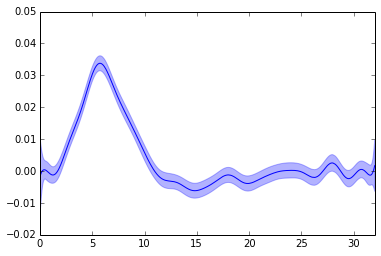

In [468]:
#mpoints = evaluation_points
mpoints = np.concatenate(hrf_measurement_points)

order = np.argsort(mpoints)  # no need for next 3 lines if evaluation points are not hrf meas
mpoints_ordered = mpoints[order]
hrf_ordered = hrf_values[order]
hrf_var_ordered = hrf_var[order]

plt.plot(mpoints_ordered, hrf_ordered)
#plt.plot(mpoints_ordered, hrf_ordered, 'ro')
plt.fill_between(mpoints_ordered,
                 hrf_ordered - 1.96 * np.sqrt(hrf_var_ordered),
                 hrf_ordered + 1.96 * np.sqrt(hrf_var_ordered),
                 color=(0., 0., 1., .3))
plt.axis([0, 32, -.02, .05])

OK, so globally this seems to work, hrf estimated from betas and the design, both for regular and jittered designs. However, the estimation is **awfully sensitive to noise**

**Important TO DO** : Figure out how to combat this. Do we put a mean function and let the GP vary around it? Can we make the kernel better, e.g. non-translation-invariant to impose stronger smoothness on the tail of the HRF? What other possibilities are there?

Let us next, to complete the picture, re-generate the design using the estimated HRF.

In [556]:
def get_design_from_hrf_measures(hrf_measures, beta_indices):
    
    event_names = np.unique(np.concatenate(beta_indices)).astype('int')
    
    design = np.zeros([len(beta_indices), len(event_names)])
    pointer = 0
    
    for beta_ind, row in zip(beta_indices, design):
        measures = hrf_measures[pointer:pointer + len(beta_ind)]
        for i, name in enumerate(event_names):
            row[i] = measures[beta_ind == name].sum()
        pointer += len(beta_ind)
    return design


In [474]:
new_design = get_design_from_hrf_measures(hrf_values, beta_indices)

(-0.5, 242.5, 3.5, -0.5)

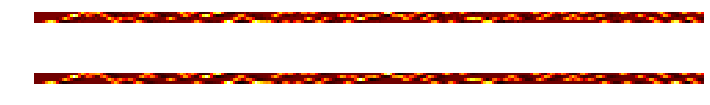

In [479]:
plt.figure(figsize=(12, 2))
plt.subplot(2, 1, 1)
plt.imshow(new_design.T, interpolation='nearest')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(design.T, interpolation='nearest')
plt.axis('off')

OK, creating the design from HRF measurements seems to work as well, so next up is to write the simplest alternating optimization algorithm.

It should take the experimental paradigm and y-values, a kernel, a noise value and a number of iterations. We can also take some initial beta values.

In [533]:
def estimate_beta_and_hrf_alternating(ys, paradigm, frametimes, kernel, noise_level,
                                      n_iter=5, hrf_length=32., initial_beta=None):
    names, onsets, durations, modulation = check_paradigm(paradigm)
    (hrf_measurement_points, visible_events,
     alphas, beta_indices, unique_events) = get_hrf_measurements(frame_times, onsets, names,
                                                 modulation=modulation,
                                                 hrf_length=hrf_length)
    pre_cov_matrix, pre_cross_cov_matrix = get_alpha_weighted_kernel_matrix(
        hrf_measurement_points, alphas, kernel)
    if initial_beta is None:
        initial_beta = np.ones(len(unique_events))
    
    beta = initial_beta.copy()
    all_hrf_values = []
    all_designs = []
    all_betas = []
    for i in range(n_iter):
        hrf_values = get_hrf_values_from_betas(ys, beta, pre_cov_matrix, 
                              pre_cross_cov_matrix, beta_indices,
                              noise_level)
        design = get_design_from_hrf_measures(hrf_values, beta_indices)
        betas = np.linalg.pinv(design).dot(ys)
        all_hrf_values.append(hrf_values)
        all_designs.append(design)
        all_betas.append(betas)
    return betas, (hrf_measurement_points, hrf_values), all_hrf_values, all_designs, all_betas


So let's check this function. Let's choose a paradigm and generate some corresponding data as above and then run the algorithm

In [577]:
paradigm = jittered_paradigm

TR = 2
measurement_times = np.arange(0., event_times.max() + 10, TR)
full_design = make_design_matrix(measurement_times, paradigm=paradigm, period_cut=64)

design = full_design[event_types].values  # forget about drifts for the moment
beta = rng.randn(len(event_types))
noise_level = .01
ys = design.dot(beta) + rng.randn(design.shape[0]) * noise_level


In [588]:
kernel = partial(k, gamma=10.)
output = estimate_beta_and_hrf_alternating(ys, paradigm, measurement_times, kernel,
                                           noise_level=1., n_iter=10, hrf_length=24)

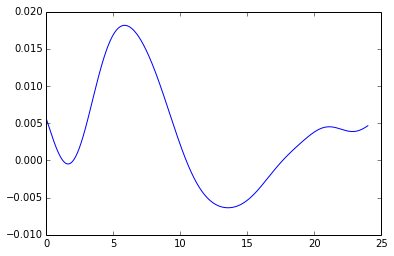

In [589]:
hrf_measurement_points = np.concatenate(output[1][0])
order = np.argsort(hrf_measurement_points)
hx, hy = hrf_measurement_points[order], output[1][1][order]
plt.plot(hx, hy)

## Evaluation

Before we continue, we need to figure out a way of evaluating our models in the most neutral possible way.

Assuming we can write some sort of probabilistic model for everything we test (even if it is only on the additive Gaussian noise of a standard GLM), we can fit our model on some data and then evaluate the **loglikelihood of new data** on the learnt model.

*"Pour fixer les idées"*, let us assume some sort of session/run structure with realistic time lengths. E.g. 
- one run takes 10-15 minutes (at TR=2 that is 300-450 measurements)
- one scanner session contains 6-9 runs (around 1.5h of acquisition), but each run has different drifts
- later we could also do multiple sessions allowing some sort of slight change in global intensity of activation or even slightly different beta maps

We should thus generate this type of synthetic data using canonical HRFs, in several parametrized versions, as follows:

- different HRFs: Let us for the moment just do different peak times, e.g. 3, 4, 5, 6, 7 sec. We could also do different widths, but that is probably secondary
- different mean/min/max distance between events, starting from so distant that HRFs never overlap and going down to 4 or even 3 seconds between events. Naturally for more event spacing we will get less events, but it is not realistic to extend measurement time in one run, so this is a real-world trade-off
- different Gaussian noise levels on a logarithmic grid, possibly also including 0 noise (not sure if AR(1) is in scope here). We need several examples per noise level.

We should evaluate first a classical GLM with every possible HRF peak setting on all these data. Where the peaks correspond, the estimates should yield the best loglikelihood on held-out data.

How do we compare to held-out data if there are drifts? Maybe we simply need to project them out, knowing that this can also kill some signal, but that is also a situation of real life.

Ideally, of course, the data would be generated by something other than a linear model with canonical HRF, such as the balloon model, but here again this may be out of scope.

The HRF estimation technique needs to be compared to FIR in the case of non-jittered paradigms, and always against HRF + derivatives and Fourier basis.

### Ideas/TO DO for actually making this thing work

- As mentioned before, with mean 0, a high estimated noise variance will make the HRF shrink towards 0. We would maybe like it to shrink towards a more plausible mean.
    - this can be a canonical HRF (and would have to find the difference to another canonical HRF if a different one was used)
    - it could also be coming from some mean HRF evaluated as a GP across a region, or evaluated in a Fourier basis across a region
    - there are probably more options like that here
    - we could try to make the first or second derivative of the HRF be a Gaussian process instead of the HRF itself, but that, if I am correct, makes the kernel for the function itself look quite weird, and would necessitate the next point
    - we should constrain the HRF to be of value 0 at the beginning and the end. This is quite easy to add
- We need some form of hyperparameter selection. This goes for the kernel parameters as well as for the noise level.
    - I think Rasmussen and Williams shows a gradient descent method on training loss if the kernel is appropriately differentiable (the case for Gaussian kernel)
    - We could do analytical leave-one out, which would be so much more awesome and cool
    - depending on how many probabilistic variables we have, we may need to move over to a bayesian optimization scheme such as VEM or, heaven forbid, MCMC
- Note for the future: It would be awesome to evaluate the situations of non-linearity in the balloon model due to events being too close to each other and analy